## Drosophila Examples for Pairwise Alignment

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import sys
sys.path.insert(0,'../')
import morpho
import matplotlib.pyplot as plt
import scanpy
import numpy as np
from jupyterthemes import jtplot
jtplot.style(theme="onedork")
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
slice_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
%load_ext autoreload
%autoreload 2

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
data_dir='../data/cellbin_h5ad'
slices = [scanpy.read_h5ad(os.path.join(data_dir, "E8-10_b_S{:0>2d}.h5ad".format(index))) for index in range(5,30)]

### Exact Alignment on CPU

In [69]:
i = 10
BAS_slices = [slice.copy() for slice in slices]
sliceA = BAS_slices[i]
sliceB = BAS_slices[i + 1]
align_model_A, align_model_B, P = morpho.morpho_align_pairwise(
            model_ref=sliceA,
            model=sliceB,
            spatial_key="spatial",
            key_added="align_spatial",
            select_high_exp_genes=False,
            normalize_c=True,
            normalize_g=False,
            mode="SN",
            device="2",
            max_iter=100,
            dtype='float64',
            beta2=0.1,
            verbose=True,
            iter_key_added='iter_spatial',
            keep_size=False,
        )

|-----> Start alignment based on morph, mode: SN.
|-----> Filtered all samples for common genes. There are 8528 common genes.
|-----> Coordinates normalization params:
|-----------> Scale: 289.4297987404491.
|-----> [Start morpho alignment] in progress: 100.0000%
|-----> [Start morpho alignment] finished [0.7872s]


In [70]:
morpho.two_d_pairwise_animate(
    model_ref=align_model_A,
    model=align_model_B,
)

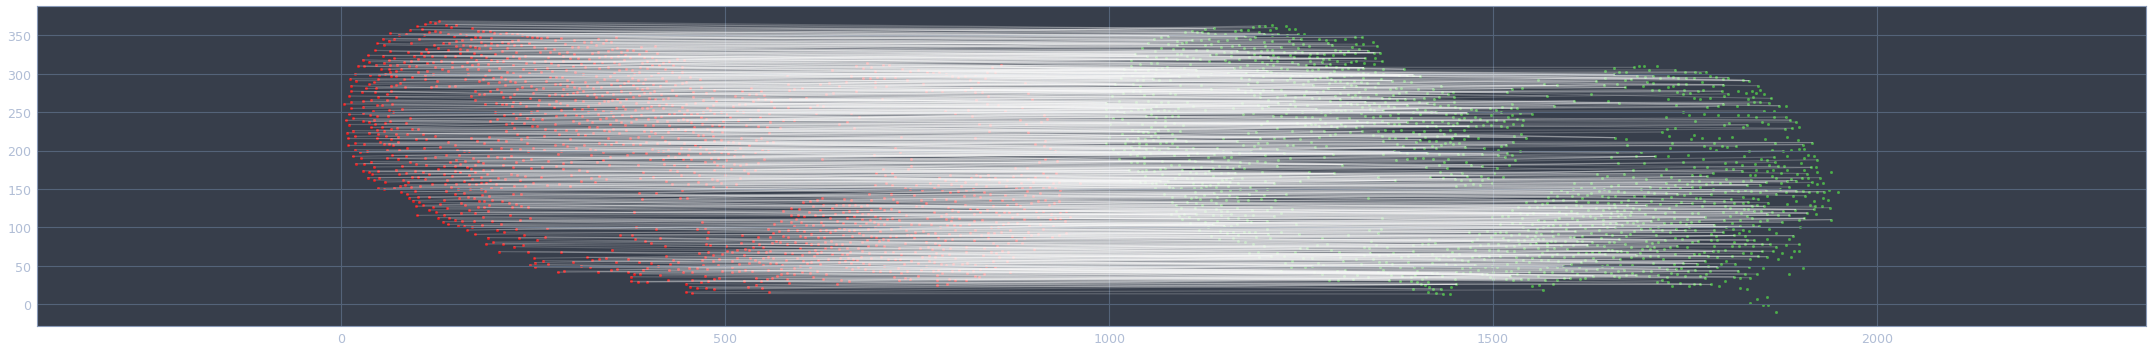

In [71]:
sliceA_align, sliceB_align = align_model_A, align_model_B
xmin,xmax = np.min([np.min(sliceB_align.obsm['align_spatial'][:,0]),np.min(sliceA_align.obsm['align_spatial'][:,0])]),np.max([np.max(sliceB_align.obsm['align_spatial'][:,0]),np.max(sliceA_align.obsm['align_spatial'][:,0])])
ymin,ymax = np.min([np.min(sliceB_align.obsm['align_spatial'][:,1]),np.min(sliceA_align.obsm['align_spatial'][:,1])]),np.max([np.max(sliceB_align.obsm['align_spatial'][:,1]),np.max(sliceA_align.obsm['align_spatial'][:,1])])
margin = 20
%matplotlib inline
fig, ax = plt.subplots(1, 1,figsize=(30,5))
dot_size = 8
for i in range(sliceA_align.obsm['align_spatial'].shape[0]):
    max_index = np.argmax(P[:,i])
    ax.plot([sliceA_align.obsm['align_spatial'][i,0],sliceB_align.obsm['align_spatial'][max_index,0] + xmax + margin],[sliceA_align.obsm['align_spatial'][i,1],sliceB_align.obsm['align_spatial'][max_index,1]],'w-',alpha=0.2)

ax.scatter(sliceA_align.obsm['align_spatial'][:,0],sliceA_align.obsm['align_spatial'][:,1],s=dot_size,c=slice_colors[0])
ax.scatter(sliceB_align.obsm['align_spatial'][:,0] + xmax + margin,sliceB_align.obsm['align_spatial'][:,1],s=dot_size,c=slice_colors[2])
ax.set_xlim([xmin-margin,xmax+margin])
ax.set_ylim([ymin-margin,ymax+margin])
ax.axis('equal')
plt.tight_layout()
plt.show()

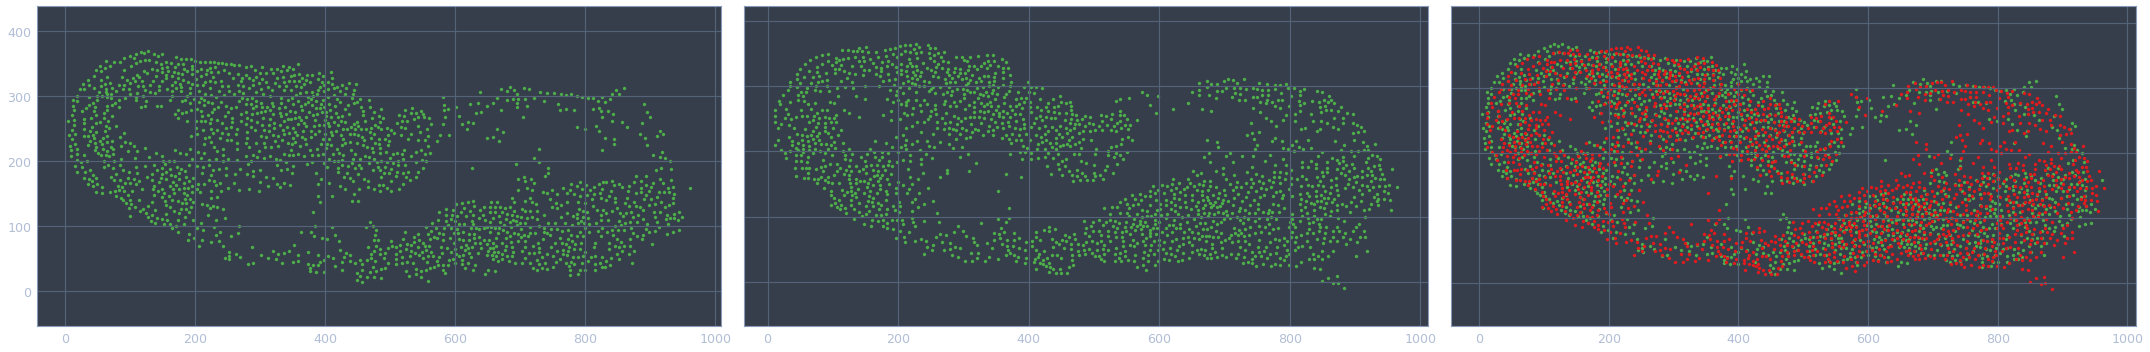

In [72]:
%matplotlib inline
fig, ax = plt.subplots(1, 3,figsize=(30,5))
plot_slices(align_model_A, align_model_B,ax,'align_spatial',slice_colors, 10)
plt.tight_layout()
plt.show()

In [73]:
import paste as pst
import ot
import time
sliceA_paste, sliceB_paste = sliceA.copy(), sliceB.copy()
t1 = time.time()
pi = pst.pairwise_align(sliceA_paste, sliceB_paste, use_gpu=True,backend = ot.backend.TorchBackend())
# pi = pst.pairwise_align(sliceA_paste, sliceB_paste, use_gpu=False)
pis = [pi]
new_slices = pst.stack_slices_pairwise([sliceA_paste, sliceB_paste], pis)
t2 = time.time()
print("Paste costs {:.5} s".format(t2-t1))

gpu is available, using gpu.
Paste costs 6.3726 s


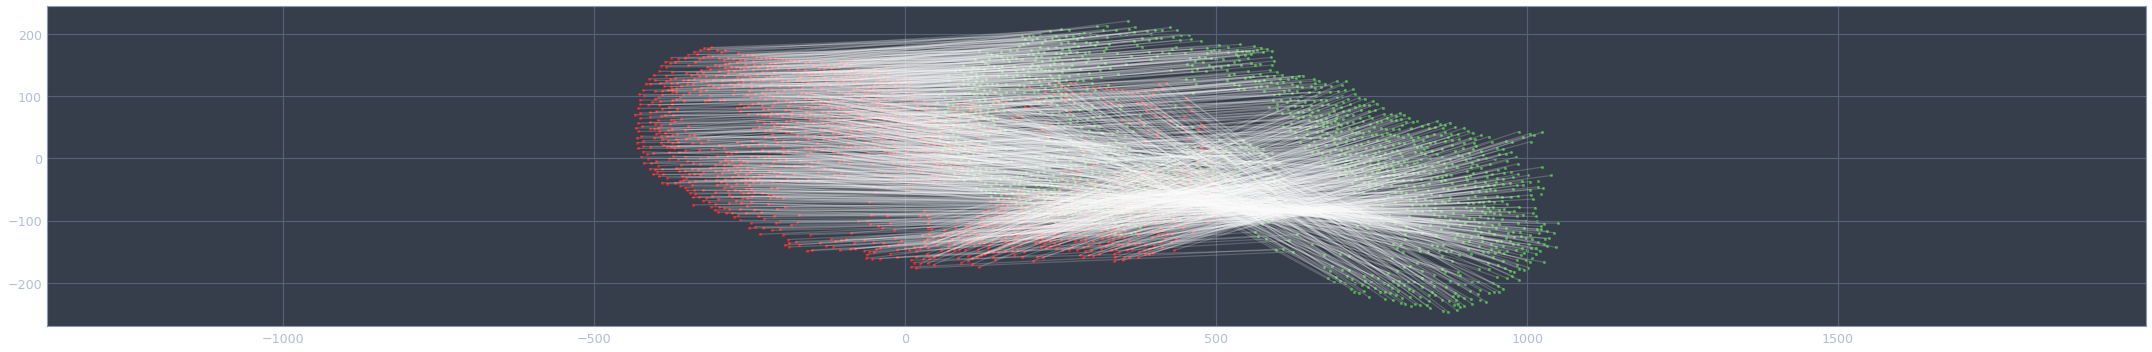

In [74]:
sliceA_align, sliceB_align = new_slices[0], new_slices[1]
xmin,xmax = np.min([np.min(sliceB_align.obsm['spatial'][:,0]),np.min(sliceA_align.obsm['spatial'][:,0])]),np.max([np.max(sliceB_align.obsm['spatial'][:,0]),np.max(sliceA_align.obsm['spatial'][:,0])])
ymin,ymax = np.min([np.min(sliceB_align.obsm['spatial'][:,1]),np.min(sliceA_align.obsm['spatial'][:,1])]),np.max([np.max(sliceB_align.obsm['spatial'][:,1]),np.max(sliceA_align.obsm['spatial'][:,1])])
margin = 20
%matplotlib inline
fig, ax = plt.subplots(1, 1,figsize=(30,5))
dot_size = 8
for i in range(sliceA_align.obsm['spatial'].shape[0]):
    max_index = np.argmax(pi.T[:,i])
    ax.plot([sliceA_align.obsm['spatial'][i,0],sliceB_align.obsm['spatial'][max_index,0] + xmax + margin],[sliceA_align.obsm['spatial'][i,1],sliceB_align.obsm['spatial'][max_index,1]],'w-',alpha=0.2)

ax.scatter(sliceA_align.obsm['spatial'][:,0],sliceA_align.obsm['spatial'][:,1],s=dot_size,c=slice_colors[0])
ax.scatter(sliceB_align.obsm['spatial'][:,0] + xmax + margin,sliceB_align.obsm['spatial'][:,1],s=dot_size,c=slice_colors[2])
ax.set_xlim([xmin-margin,xmax+margin])
ax.set_ylim([ymin-margin,ymax+margin])
ax.axis('equal')
plt.tight_layout()
plt.show()

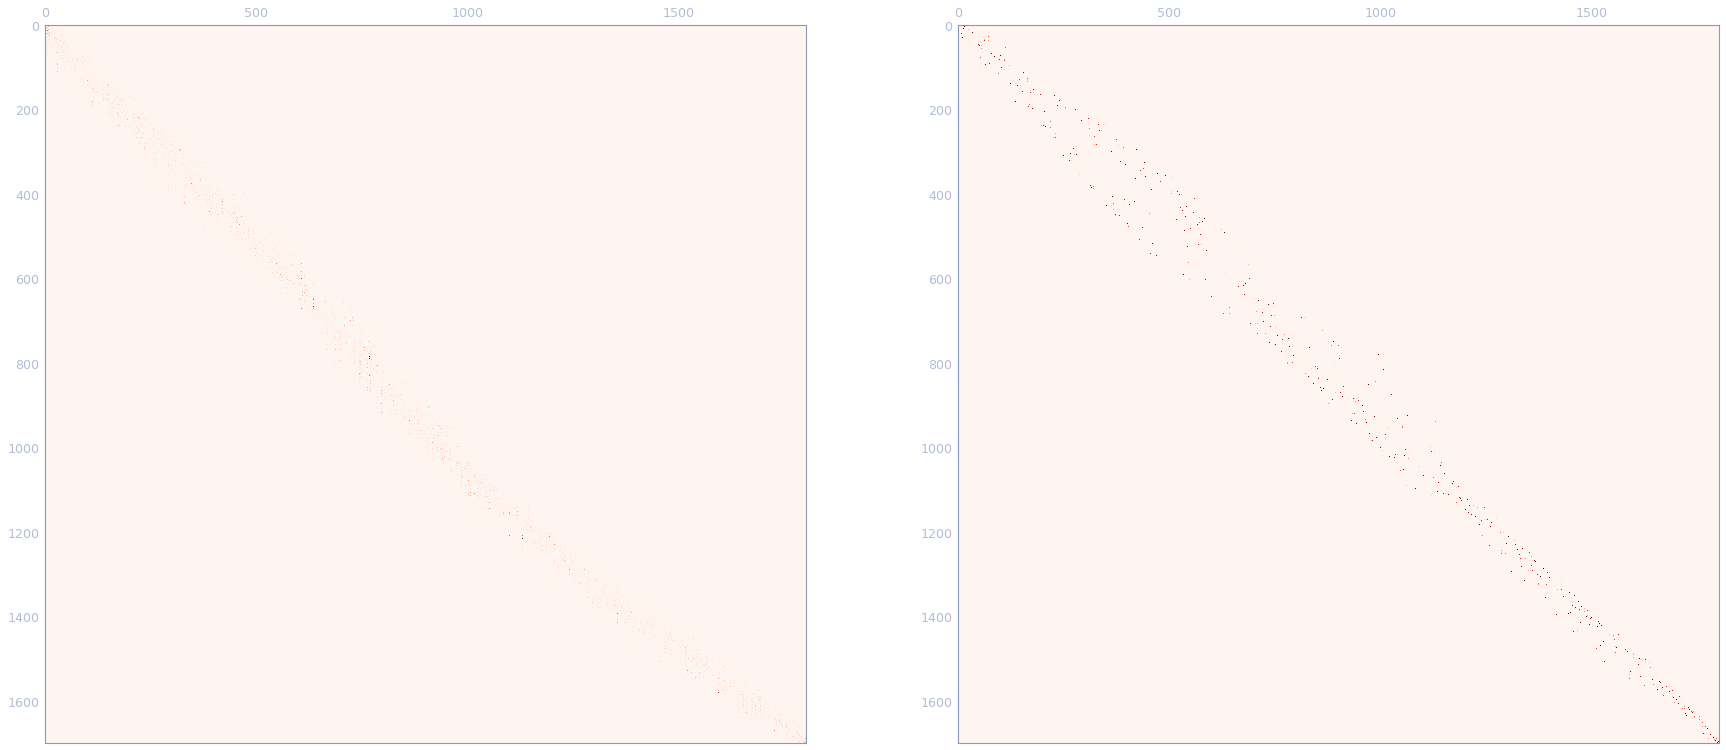

In [75]:
%matplotlib inline
vis_P = P.T.copy()
vis_P = vis_P / np.max(vis_P)
fig, axs = plt.subplots(1,2,figsize=(30,15))
axs[0].matshow(vis_P, cmap="Reds")
# ax.axis('off')
axs[0].grid(False)


vis_P = pi.copy()
vis_P = vis_P / np.max(vis_P)
vis_P[vis_P < 0.05] = 0
# fig, ax = plt.subplots(figsize=(15,15))
axs[1].matshow(vis_P, cmap="Reds")
axs[1].grid(False)
plt.show()

In [76]:
def plot_slices(sliceA_align, sliceB_align, axs, spatial_key, slice_colors,dot_size):
    xmin,xmax = np.min([np.min(sliceB_align.obsm[spatial_key][:,0]),np.min(sliceA_align.obsm[spatial_key][:,0])]),np.max([np.max(sliceB_align.obsm[spatial_key][:,0]),np.max(sliceA_align.obsm[spatial_key][:,0])])
    ymin,ymax = np.min([np.min(sliceB_align.obsm[spatial_key][:,1]),np.min(sliceA_align.obsm[spatial_key][:,1])]),np.max([np.max(sliceB_align.obsm[spatial_key][:,1]),np.max(sliceA_align.obsm[spatial_key][:,1])])
    # dot_size = 8
    margin = 20
    axs[0].scatter(sliceA_align.obsm[spatial_key][:,0],sliceA_align.obsm[spatial_key][:,1],s=dot_size,c=slice_colors[2])
    axs[0].set_xlim([xmin-margin,xmax+margin])
    axs[0].set_ylim([ymin-margin,ymax+margin])
    axs[0].axis('equal')
    axs[1].scatter(sliceB_align.obsm[spatial_key][:,0],sliceB_align.obsm[spatial_key][:,1],s=dot_size,c=slice_colors[2])
    axs[1].set_xlim([xmin-margin,xmax+margin])
    axs[1].set_ylim([ymin-margin,ymax+margin])
    axs[1].set_yticklabels([])
    axs[1].axis('equal')
    axs[2].scatter(sliceA_align.obsm[spatial_key][:,0],sliceA_align.obsm[spatial_key][:,1],s=dot_size,c=slice_colors[2])
    axs[2].scatter(sliceB_align.obsm[spatial_key][:,0],sliceB_align.obsm[spatial_key][:,1],s=dot_size,c=slice_colors[0])
    axs[2].set_xlim([xmin-margin,xmax+margin])
    axs[2].set_ylim([ymin-margin,ymax+margin])
    axs[2].set_yticklabels([])
    axs[2].axis('equal')

TypeError: plot_slices() missing 1 required positional argument: 'dot_size'

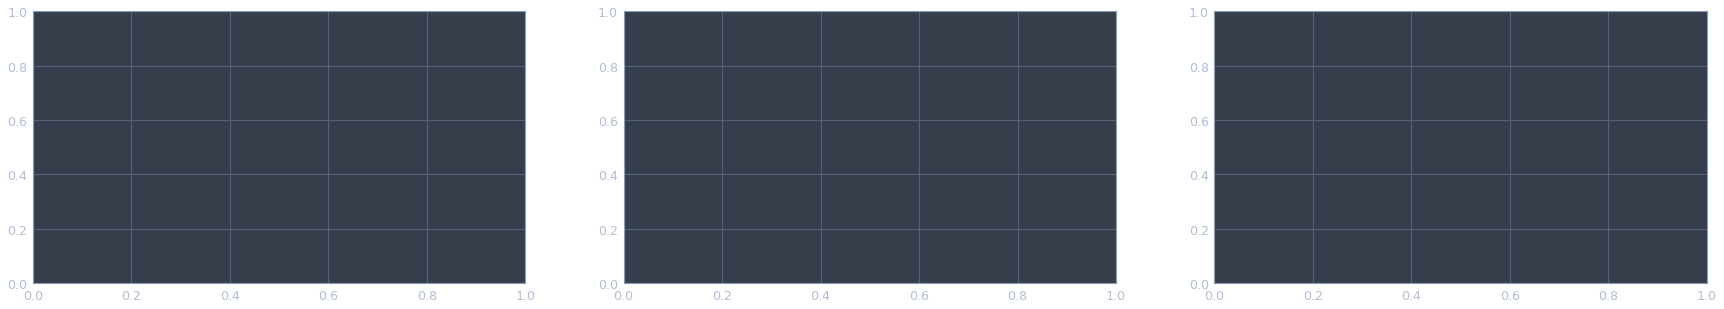

In [77]:
%matplotlib inline
fig, ax = plt.subplots(1, 3,figsize=(30,5))
plot_slices(new_slices[0], new_slices[1],ax,'spatial',slice_colors)
plt.tight_layout()
plt.show()

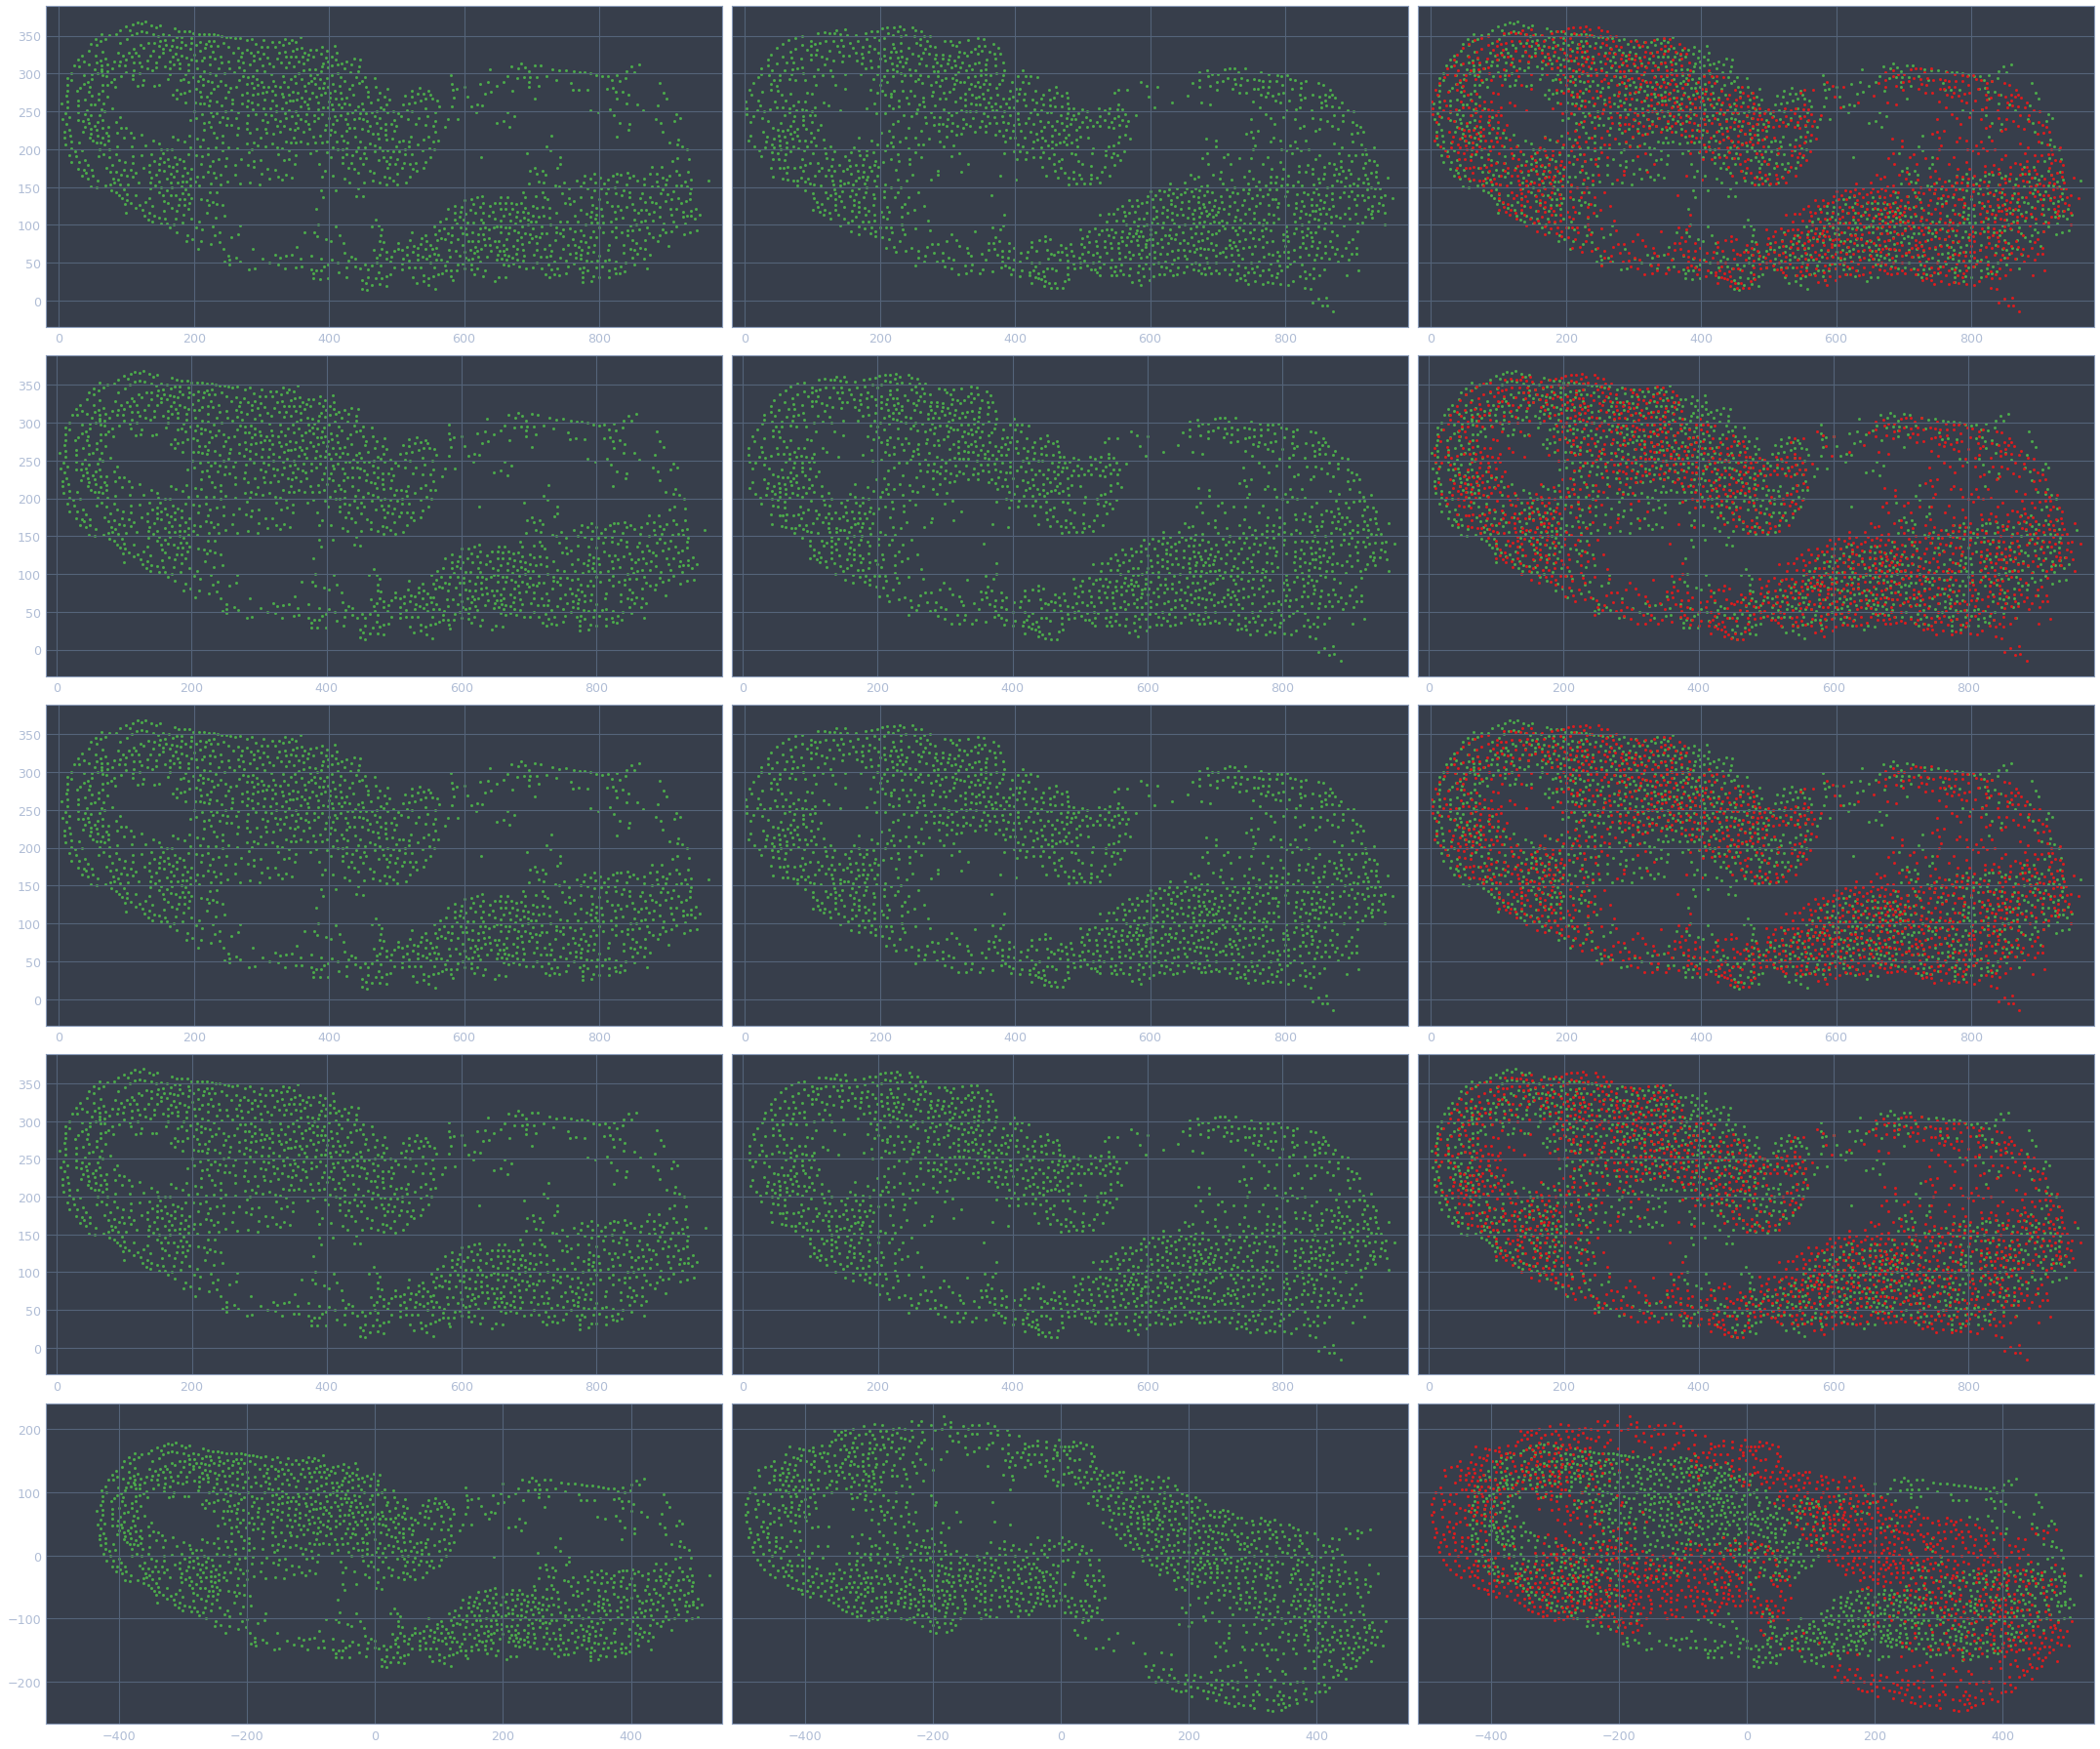

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(5, 3,figsize=(30,25))
plot_slices(sliceA_align, sliceB_align,axs[0],'align_spatial',slice_colors)
plot_slices(sliceA_align_SVI, sliceB_align_SVI,axs[1],'align_spatial',slice_colors)
plot_slices(sliceA_align_GPU, sliceB_align_GPU,axs[2],'align_spatial',slice_colors)
plot_slices(sliceA_align_GPU_SVI, sliceB_align_GPU_SVI,axs[3],'align_spatial',slice_colors)
plot_slices(new_slices[0], new_slices[1],axs[4],'spatial',slice_colors)
plt.tight_layout()
plt.show()

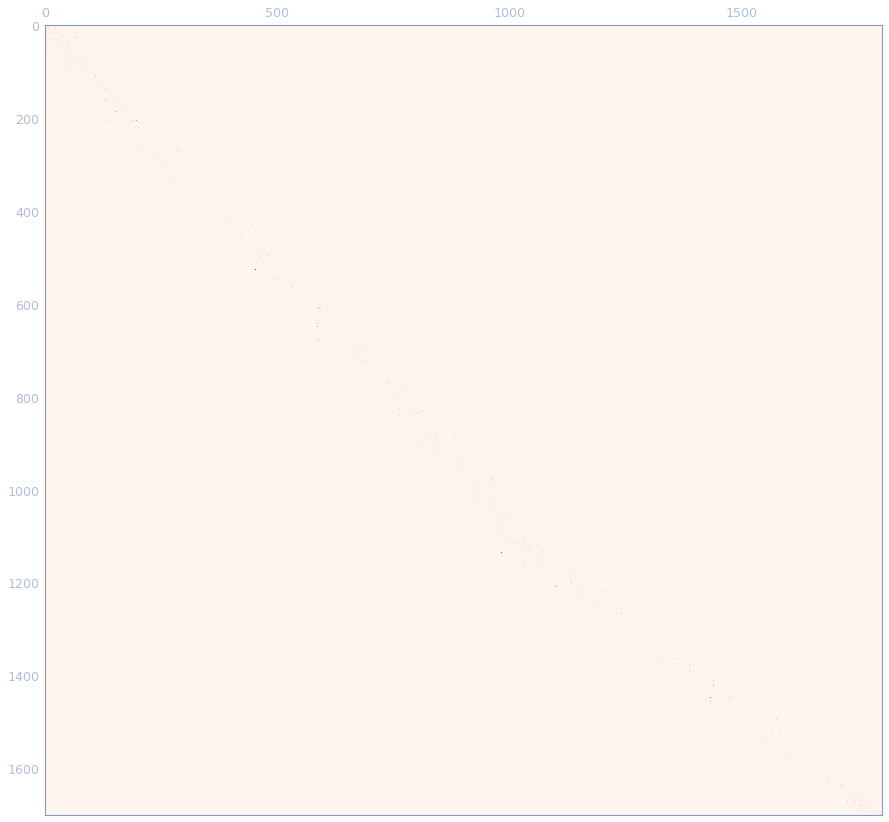

In [ ]:
%matplotlib inline
vis_P = P.T.copy()
vis_P = vis_P / np.max(vis_P)
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(vis_P, cmap="Reds")
# ax.axis('off')
ax.grid(False)
plt.show()

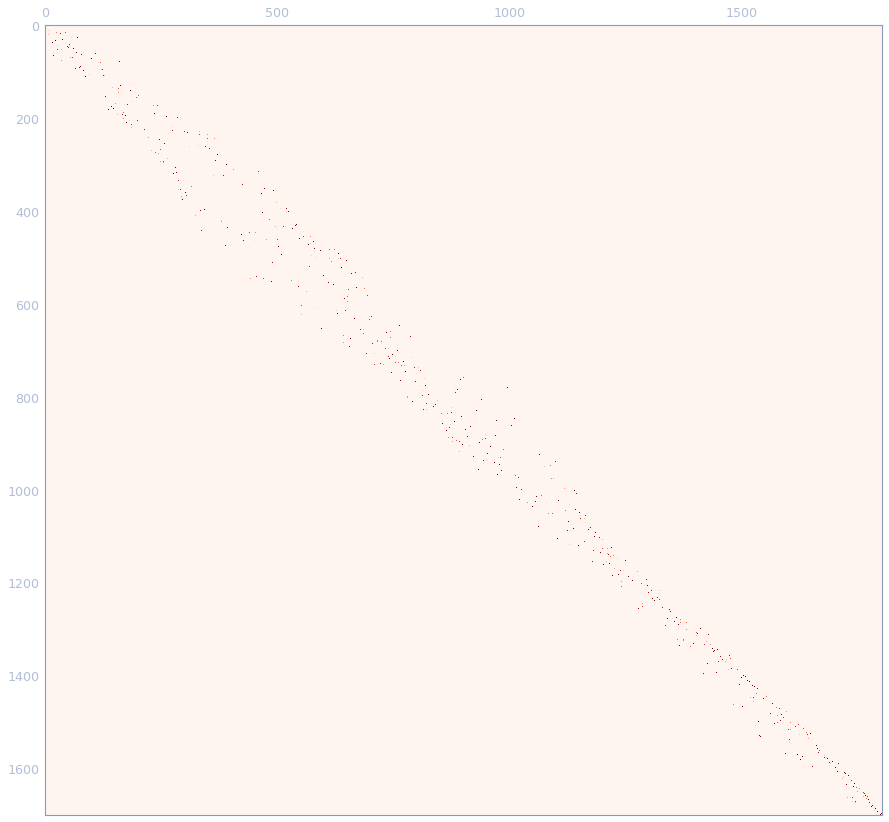

In [ ]:
%matplotlib inline
vis_P = pi.copy()
vis_P = vis_P / np.max(vis_P)
vis_P[vis_P < 0.05] = 0
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(vis_P, cmap="Reds")
ax.grid(False)
plt.show()